In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, InputLayer, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

In [9]:
import yfinance as yf
import datetime
from datetime import date

# Define the ticker symbol and date range
ticker = '^NSEBANK'
start_date = datetime.datetime(2007, 1, 1)
end_date = date.today()

# Fetch the data using yfinance
data = yf.download(ticker, start=start_date, end=end_date)

# Select the adjusted close prices
# print(data.columns)
# data = data[['Adj Close']]
# data.columns = ['Close']

# Display the first few rows of the data
df = data
print(df.columns)
print(df)


[*********************100%%**********************]  1 of 1 completed

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
                    Open          High           Low         Close  \
Date                                                                 
2007-09-17   6898.000000   6977.200195   6843.000000   6897.100098   
2007-09-18   6921.149902   7078.950195   6883.600098   7059.649902   
2007-09-19   7111.000000   7419.350098   7111.000000   7401.850098   
2007-09-20   7404.950195   7462.899902   7343.600098   7390.149902   
2007-09-21   7378.299805   7506.350098   7367.149902   7464.500000   
...                  ...           ...           ...           ...   
2024-06-10  49808.148438  50252.949219  49622.750000  49780.898438   
2024-06-11  49751.199219  49970.300781  49530.449219  49705.750000   
2024-06-12  49857.449219  50233.398438  49697.351562  49895.101562   
2024-06-13  50179.000000  50186.449219  49799.648438  49846.699219   
2024-06-14  49993.949219  50102.601562  49693.351562  50002.000000   

          

In [10]:
def calc_indicators(df):
    ## macd
    data = ta.trend.MACD(df["Close"], 12, 26, 9)
    df["macd"] = data.macd()
    df["macd_signal"] = data.macd_signal()
    
    ## rsi
    data = ta.momentum.RSIIndicator(df["Close"], 14)
    df["rsi"] = data.rsi()
    
    ## obv
    data = ta.volume.OnBalanceVolumeIndicator(df["Close"], df["Volume"])
    df["obv"] = data.on_balance_volume()
    
    ## ema
    data = ta.trend.ema_indicator(df["Close"], 12)
    df["ema_12"] = data
    
    ## remove redundancy
    df = df.drop([ "Open", "High", "Low", "Volume","Adj Close"], axis=1)
    df = df.dropna()
    
#     df = df[["Close", "macd", "macd_signal", "rsi", "obv", "ema_12"]]
    
    # normalize
#     df=(df-df.min())/(df.max()-df.min())
    
    return df
    
df = calc_indicators(df)
df

,Close,macd,macd_signal,rsi,obv,ema_12
Date,,,,,,
2007-11-02,9560.700195,-429.931701,-301.149012,74.858693,0,8724.973803
2007-11-05,9397.549805,-451.737695,-331.266749,70.424964,0,8828.447034
2007-11-06,9216.299805,-449.215465,-354.856492,65.764862,0,8888.116691
2007-11-07,9090.200195,-432.060867,-370.297367,62.658383,0,8919.206461
2007-11-08,8876.250000,-396.629632,-375.563820,57.680053,0,8912.597775
...,...,...,...,...,...,...
2024-06-10,49780.898438,-360.489328,-270.841301,56.026792,2094033500,49087.760908
2024-06-11,49705.750000,-383.084690,-293.289979,55.558196,2093905000,49182.836153
2024-06-12,49895.101562,-411.526939,-316.937371,56.544434,2094116700,49292.415447


In [11]:
data = np.array(df)
data.shape

(3797, 6)

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
data

array([[0.13058287, 0.23226402, 0.26276942, 0.82485329, 0.04174681,
        0.11057976],
       [0.12715823, 0.2276681 , 0.25550739, 0.76649787, 0.04174681,
        0.11283827],
       [0.12335368, 0.22819969, 0.24981939, 0.705163  , 0.04174681,
        0.11414067],
       ...,
       [0.97722834, 0.23614309, 0.25896251, 0.58380648, 0.99964632,
        0.9960423 ],
       [0.97621234, 0.23324869, 0.25373873, 0.57928761, 0.99958882,
        0.99790357],
       [0.97947221, 0.22939132, 0.24867712, 0.59113376, 0.99965972,
        1.        ]])

In [13]:
train_ratio=0.9
val_ratio=0.05

train_data = data[:int(train_ratio*len(data))]
val_data = data[int(train_ratio*(len(data))):int((train_ratio+val_ratio)*len(data))]
test_data = data[int((train_ratio + val_ratio)*len(data)):]

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(3417, 6)
(190, 6)
(190, 6)


In [14]:
def createXy(data, period=10, frame=10):
    Xs=[]
    ys=[]
    for i in range(period, len(data)-frame+1):
        Xs.append(data[i-period:i])
        ys.append(data[i+frame-1, 0])
    return np.array(Xs), np.array(ys)

# frame = 1 for getting next day prediction
X_train, y_train = createXy(train_data, 100, 1)
X_val, y_val = createXy(val_data, 100, 1)
X_test, y_test = createXy(test_data, 100, 1)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3317, 100, 6) (3317,)
(90, 100, 6) (90,)
(90, 100, 6) (90,)


# create Model

In [15]:
model=Sequential()
model.add(InputLayer(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(150,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dense(1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 150)       │        94,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 100)       │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,321 (880.16 KB)

 Trainable params: 225,321 (880.16 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001))
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1)

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - loss: 6.8113e-04 - val_loss: 0.0013
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 4.3267e-04 - val_loss: 0.0017
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - loss: 4.6513e-04 - val_loss: 5.7722e-04
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - loss: 4.2002e-04 - val_loss: 7.9477e-05
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 4.5963e-04 - val_loss: 5.2464e-04
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 4.4779e-04 - val_loss: 0.0017
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 5.4010e-04 - val_loss: 3.6461e-04
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 4.0406e-04 - val_loss: 0.0010
Epoch 9/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - loss: 4.3744e-04 - val_loss: 1.8089e-04
Epoch 10/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 4.4709e-04 - val_loss: 3.0955e-04
Epoch 11/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 

In [20]:
pred = model.predict(X_test)
pred.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


(90, 1)

[]

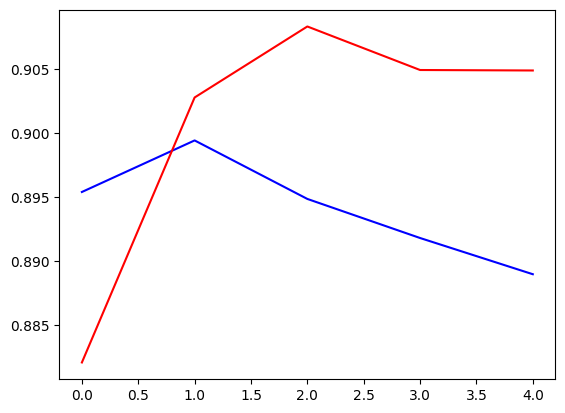

In [25]:
# here predicted graph is lagging
plt.plot(y_test[:5], color="b")
plt.plot(pred[:5], color="r")
plt.plot()

[]

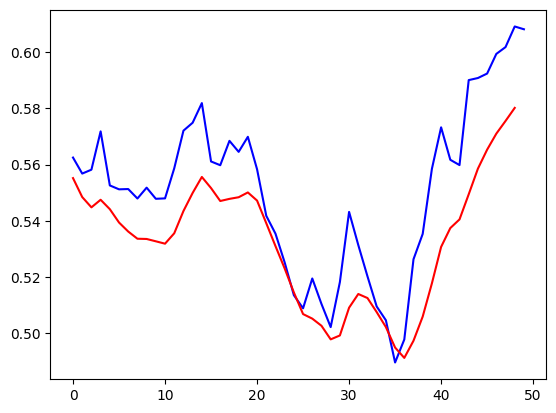

In [26]:
# after shifting the predicting graph
plt.plot(y_test[:50], color="b")
plt.plot(pred[1:2], color="r")
plt.plot()